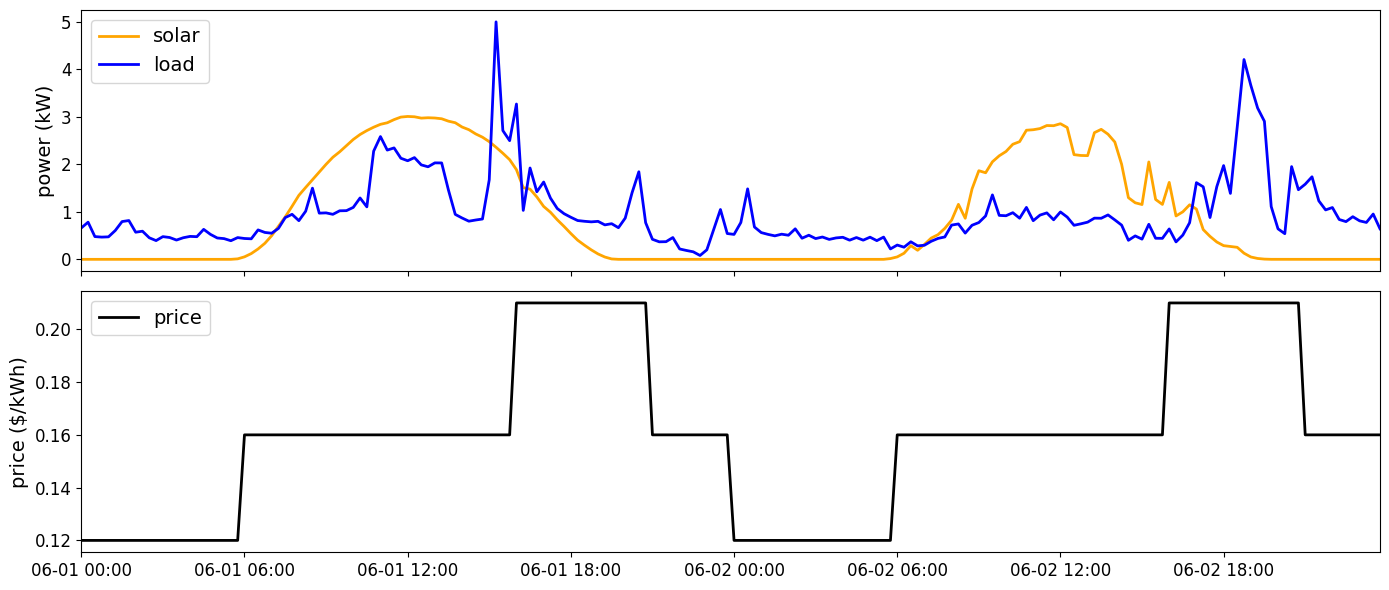

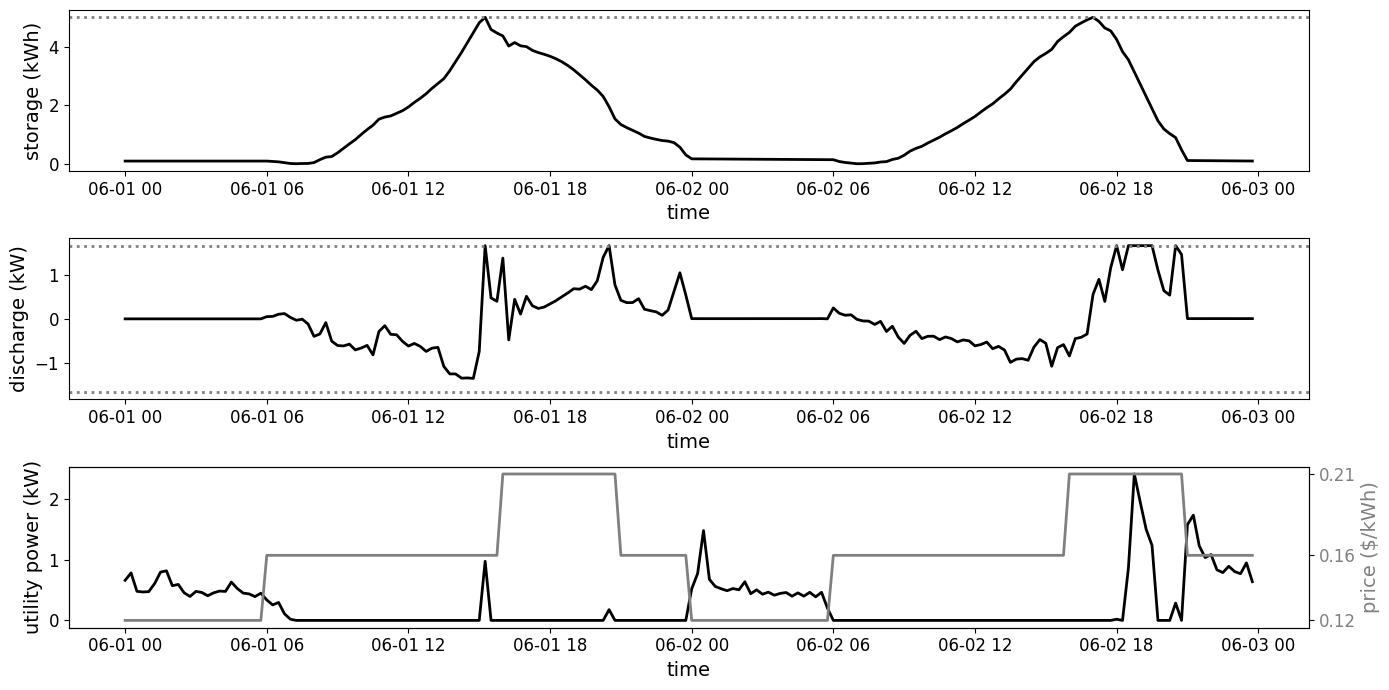

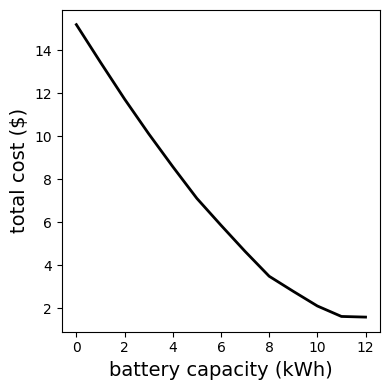

In [1]:
import cvxpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ------ LOAD DATA FROM CSV FILE ------
# We obtained the data from Kaggle: https://www.kaggle.com/datasets/pythonafroz/photovoltaic-generation-and-load-demand-datasets
# Its description is as follows:
# The residential building, with two occupants and a 200 m2 approximately indoor area, is located in Nicosia, Cyprus. 
# The building is equipped with a rooftop photovoltaic system consist of a 5 kVA Solar Edge Inverter (SE5K), integrating 18 x REC310PE72 PV panels. 
# The PV panels are installed with 3o inclination angle (almost flat) an 190o azimuth angle (almost south direction). 
# We found that the solar generation was more than the load overall and with enough storage no utility power was needed.
# Therefore, we decided to multiply the solar generation by a factor of 0.7 
# and multiply the load by a factor of 2.5 and clip between (0, 5) to make the problem more interesting.
df = pd.read_csv('residential_data.csv', index_col=0, parse_dates=True)
solar = df['solar'].to_numpy()
load = df['load'].to_numpy()
price = df['price'].to_numpy()

# ------ PLOT SOLAR POWER, LOAD AND TIME OF USE PRICE DATA ------
times = df.index.to_pydatetime()
start_datetime = datetime(2022, 6, 1, 0, 0)
end_datetime = datetime(2022, 6, 2, 23, 45)
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
axes[0].plot(times, solar, label='solar', color='orange', linewidth=2)
axes[0].plot(times, load, label='load', color='blue', linewidth=2)
axes[0].set_ylabel('power (kW)', fontsize=14)
axes[0].legend(fontsize=14, loc='upper left')
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(False)

axes[1].plot(times, price, label='price', color='black', linewidth=2)
axes[1].set_ylabel('price ($/kWh)', fontsize=14)
axes[1].legend(fontsize=14, loc='upper left')
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(False)
tick_times = [start_datetime + timedelta(hours=6*i) 
                for i in range(int(((end_datetime - start_datetime).total_seconds()) // 3600 // 6) + 1)]
plt.xticks(tick_times, [dt.strftime('%m-%d %H:%M') for dt in tick_times], rotation=0)
plt.xlim(start_datetime, end_datetime)
plt.tight_layout()
plt.savefig('solar_load_price.pdf')
plt.show()

# ------ MAIN FUNCTION TO SOLVE RESIDENTIAL ENERGY MANAGEMENT PROBLEM USING CVXPY ------
def residential_energy_management_cvxpy(p, l, B, Q, S, T, lam):
    q, b, u, s = cp.Variable(T+1), cp.Variable(T), cp.Variable(T), cp.Variable(T)
    obj = p.T @ u + lam * cp.norm(b, 1)
    cons = [0 <= q, q <= Q, 0 <= u, cp.abs(b) <= B, 0 <= s, s <= S]
    cons+= [u + s + b == l, q[1:] == q[:-1] - 0.25 * b, q[0] == q[-1]]
    prob = cp.Problem(cp.Minimize(obj), cons)
    prob.solve()
    q = q.value
    b = b.value
    u = u.value
    s = s.value
    return q, b, u, s

# ------ SOLVE RESIDENTIAL ENERGY MANAGEMENT PROBLEM REPEATEDLY FOR DIFFERENT BATTERY CAPACITIES ------
lam = 0.03
T = len(solar)
battery_capacities = np.linspace(0, 12, 13) # 13 points between 0 and 12 kWh
total_costs = np.zeros(len(battery_capacities))
q_s = np.zeros((len(battery_capacities), T+1))
b_s = np.zeros((len(battery_capacities), T))
u_s = np.zeros((len(battery_capacities), T))
s_s = np.zeros((len(battery_capacities), T))

for j,Q in enumerate(battery_capacities):
    B = Q/3
    q, b, u, s = residential_energy_management_cvxpy(price, load, B, Q, solar, T, lam)
    total_costs[j] = np.sum(np.multiply(price, u))
    q_s[j,:] = q
    b_s[j,:] = b
    u_s[j,:] = u
    s_s[j,:] = s
    
# ------ PICK A PARTICULAR BATTERY CAPACITY AND PLOT THE RESULTS ------
index = 5 # pick the 6th battery capacity which corresponds to 5 kWh
Q = battery_capacities[index]
B = Q/3
q = q_s[index]
b = b_s[index]
u = u_s[index]

plt.figure(figsize=(14, 7))

# First subplot
plt.subplot(3, 1, 1)
plt.plot(times, q[:-1], label=r'$q_t$', color='black', linewidth=2)
plt.xlabel('time', fontsize=14)
plt.ylabel('storage (kWh)', fontsize=14)
plt.axhline(y = Q, linestyle=':', color='gray', linewidth=2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(False)

# Second subplot
plt.subplot(3, 1, 2)
plt.plot(times, b, label=r'$b_t$', color='black', linewidth=2)
plt.xlabel('time', fontsize=14)
plt.ylabel('discharge (kW)', fontsize=14)
plt.axhline(y = B, linestyle=':', color='gray', linewidth=2)
plt.axhline(y = -B, linestyle=':', color='gray', linewidth=2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(False)

# Third subplot with dual y-axes
ax1 = plt.subplot(3, 1, 3)
ax1.plot(times, u, label=r'$u_t$', color='black', linewidth=2)
ax1.set_xlabel('time', fontsize=14)
ax1.set_ylabel('utility power (kW)', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(False)
ax2 = ax1.twinx()
ax2.plot(times, price, label=r'$p_t u_t$', color='gray', linewidth=2)
ax2.set_ylabel('price ($/kWh)', color='gray', fontsize=14) 
ax2.tick_params(axis='y', labelcolor='gray', labelsize=12)
ax2.set_yticks([0.12, 0.16, 0.21])
ax2.set_yticklabels([f"{tick:.2f}" for tick in [0.12, 0.16, 0.21]])
plt.tight_layout()
plt.savefig('profiles.pdf')
plt.show()

# ------ PLOT STORAGE / COST TRADE-OFF CURVE ------
plt.figure(figsize=(4, 4))
plt.plot(battery_capacities, total_costs, label='cost', color='black', linewidth=2)
plt.xlabel('battery capacity (kWh)', fontsize=14)
plt.ylabel('total cost ($)', fontsize=14)
plt.tight_layout()
plt.savefig('storage_vs_cost.pdf')
plt.show()